In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

import datetime
import itertools
from pathlib import Path
import os.path
import random
import matplotlib.cm as cm
import cv2

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

# Helper functions:

In [3]:
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.

    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
    number of subdiretories in dir_path
    number of images (files) in each subdirectory
    name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
    
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback function/instance to store log files.

    Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

    Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

# Generate the data

1. Walk through each directory and get filepaths and labels for each images
2. Select 15 species randomly from image_df
3. Create a panda dataframe called selected_df

In [4]:
# walk through each directory
dataset = "./train"
walk_through_dir(dataset);

There are 500 directories and 0 images in './train'.
There are 0 directories and 166 images in './train\ABBOTTS BABBLER'.
There are 0 directories and 180 images in './train\ABBOTTS BOOBY'.
There are 0 directories and 179 images in './train\ABYSSINIAN GROUND HORNBILL'.
There are 0 directories and 137 images in './train\AFRICAN CROWNED CRANE'.
There are 0 directories and 154 images in './train\AFRICAN EMERALD CUCKOO'.
There are 0 directories and 137 images in './train\AFRICAN FIREFINCH'.
There are 0 directories and 155 images in './train\AFRICAN OYSTER CATCHER'.
There are 0 directories and 187 images in './train\AFRICAN PIED HORNBILL'.
There are 0 directories and 179 images in './train\AFRICAN PYGMY GOOSE'.
There are 0 directories and 133 images in './train\ALBATROSS'.
There are 0 directories and 161 images in './train\ALBERTS TOWHEE'.
There are 0 directories and 165 images in './train\ALEXANDRINE PARAKEET'.
There are 0 directories and 166 images in './train\ALPINE CHOUGH'.
There are 0 d

In [5]:
image_dir = Path(dataset)

# get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
"""
This code is using the pandas library to filter a DataFrame called image_df.  
The code is randomly selecting 15 unique labels from the 'Label' column of image_df and  
storing them in the random_list variable using the random.sample() function.  
Then, the code is selecting all rows from image_df where the 'Label' column is in random_list,  
and storing the result in random_df.
"""
random_list = random.sample(list(image_df['Label'].unique()), 15)
random_df = image_df[image_df['Label'].isin(random_list)]

In [7]:
random_df.reset_index(inplace=True)
selected_df = random_df.copy()
selected_df.drop("index", axis=1, inplace=True)

In [33]:
selected_df.Label.unique()

array(['BLACK THROATED HUET', 'BLUE DACNIS', 'CHIPPING SPARROW',
       'CRESTED CARACARA', 'CURL CRESTED ARACURI', 'HIMALAYAN MONAL',
       'HORNED SUNGEM', 'HOUSE FINCH', 'INDIAN VULTURE',
       'JANDAYA PARAKEET', 'JAVA SPARROW', 'RED BILLED TROPICBIRD',
       'REGENT BOWERBIRD', 'SCARLET FACED LIOCICHLA', 'SURF SCOTER'],
      dtype=object)

In [9]:
selected_df.to_csv("selected_df.csv", index=False)

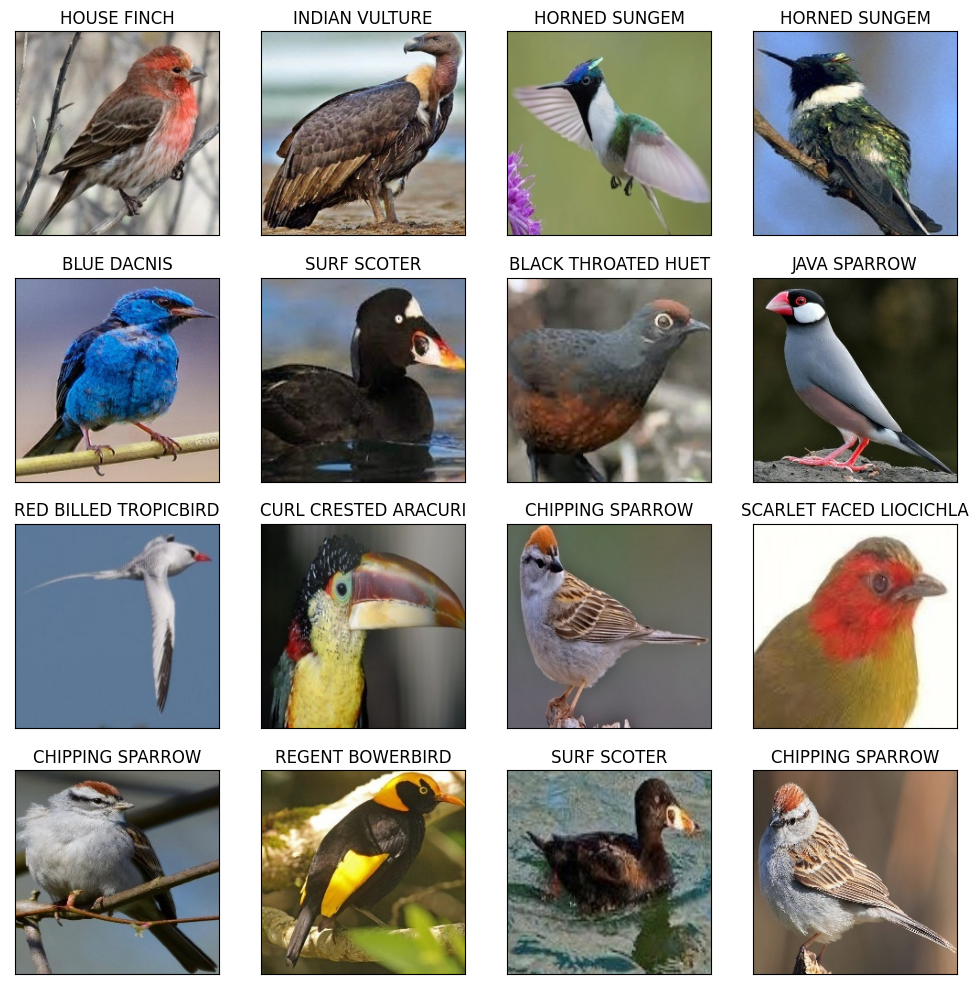

In [10]:
# display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(selected_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(selected_df.iloc[random_index[i]]["Filepath"]))
    ax.set_title(selected_df.iloc[random_index[i]]["Label"])

plt.tight_layout()

# Separate dataset in to train_df, test_df, valid_df 

In [11]:
# separate in train and test data
train_df, test_df = train_test_split(selected_df, test_size=0.2, shuffle=True, random_state=42)

In [12]:
# separate 10% of train into valid, this is unseen by the model
train_df, valid_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=42)

In [13]:
# save the valid dataframe into a csv, so that we can load it with the model later
valid_df.to_csv("valid_df.csv", index=False)

### A bit about the pre-trained model (MobilenetV2) and the weights (ImageNet) being used

#### Model
MobileNetV2 is an efficient neural network for mobile devices that achieves high accuracy and  
performance while minimizing computational cost. It uses depthwise separable convolutions and  
linear bottlenecks to reduce the number of parameters and computational cost,  
and includes several other optimizations such as an inverted residual structure and feature map pooling. 

#### Weights
ImageNet is a dataset of over 14 million images organized into 21,000 categories.  
It's commonly used for training and evaluating computer vision models,  
particularly for object classification and detection tasks.  
The images are high-resolution color photographs,  
and are annotated with bounding boxes indicating the location of objects in the image.

![MobilenetV2 Architecture Overview](mobinetv2_architecture.png)

In [14]:
# these two ImageDataGenerator instances are being used to create generators of image data  
# that can be used to train and test a CNN using the MobileNet V2 architecture in TensorFlow
# it applies normalization and other transformations to the image data to prepare it for input into the MobileNetV2 architecture

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [15]:
# split the data into three categories
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)


Found 2909 validated image filenames belonging to 15 classes.
Found 1010 validated image filenames belonging to 15 classes.
Found 727 validated image filenames belonging to 15 classes.


In [16]:
# resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

**Batch size** : 32

**Epochs** : 50

**Input Shape** : (224, 224, 3)

**Output layer** : 15

In [17]:
# load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [18]:
# create checkpoint callback
checkpoint_path = "birds_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [19]:
# setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor="val_loss",
                               patience=5,
                               restore_best_weights = True)

## A bit about our model

removed the output layer from the pretrained model.  
added 2 dense layers of 256 neurons with dropouts inbetween,  
to prevent overfitting.  

our final layer transforms the output of the previous layer  
into a probability distribution (softmax) over the possible classes (15)

In [20]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(15, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "bird_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/bird_classification/20230323-173250
Epoch 1/50
91/91 [==============================] - 29s 301ms/step - loss: 1.7673 - accuracy: 0.5559 - val_loss: 0.6676 - val_accuracy: 0.9601
Epoch 2/50
91/91 [==============================] - 27s 293ms/step - loss: 0.4821 - accuracy: 0.9182 - val_loss: 0.1644 - val_accuracy: 0.9752
Epoch 3/50
91/91 [==============================] - 27s 291ms/step - loss: 0.1948 - accuracy: 0.9660 - val_loss: 0.0819 - val_accuracy: 0.9807
Epoch 4/50
91/91 [==============================] - 27s 294ms/step - loss: 0.1226 - accuracy: 0.9746 - val_loss: 0.0588 - val_accuracy: 0.9849
Epoch 5/50
91/91 [==============================] - 26s 291ms/step - loss: 0.0804 - accuracy: 0.9825 - val_loss: 0.0455 - val_accuracy: 0.9821
Epoch 6/50
91/91 [==============================] - 27s 293ms/step - loss: 0.0673 - accuracy: 0.9873 - val_loss: 0.0361 - val_accuracy: 0.9862
Epoch 7/50
91/91 [==============================] - 27s 293

In [21]:
# saving the model
model.save("model.h5")

In [22]:
results = model.evaluate(test_images, verbose=1)

print()
print(f"Test Loss: {results[0]:.3f}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")

32/32 [==============================] - 7s 230ms/step - loss: 0.0198 - accuracy: 0.9931

Test Loss: 0.020
Test Accuracy: 99.31%


# Visualization

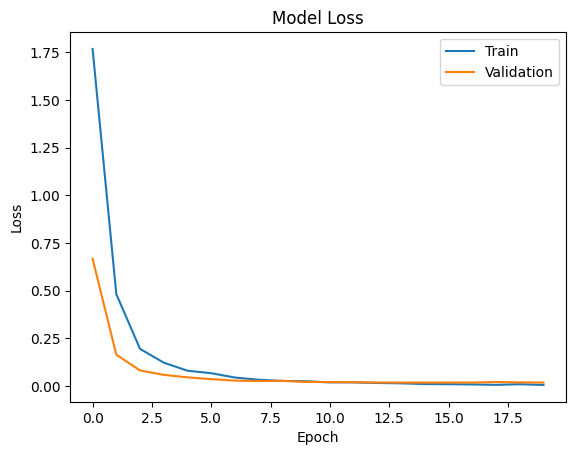

In [23]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend(loc='best')

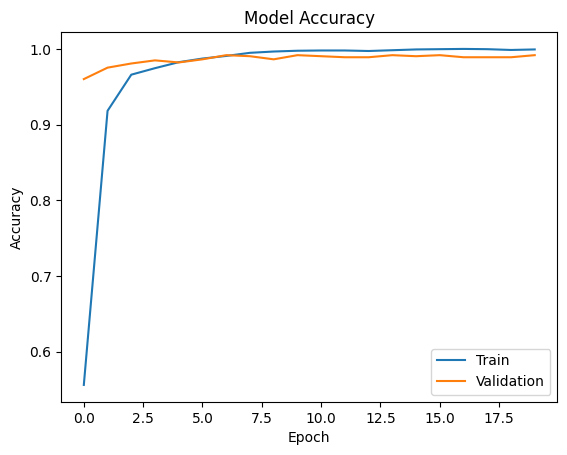

In [24]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model Accuracy')
plt.legend(loc='best')

In [25]:
# predict the label of the test_images
pred = model.predict(test_images) # every image gets a list of 15 predictions
pred = np.argmax(pred, axis=1) # we use numpy to simply return the highest prediction for each nested lists

# map the label
labels = (train_images.class_indices) # dictionary that maps the class names to their corresponding integer labels
labels = dict((v,k) for k,v in labels.items()) # swapping string class name with integer class label
pred = [labels[k] for k in pred] # looks up the class name for each predicted label using the newly created dictionary

# display the result
print(f'The first 5 predictions: {pred[:5]}')

32/32 [==============================] - 8s 226ms/step
The first 5 predictions: ['SCARLET FACED LIOCICHLA', 'CURL CRESTED ARACURI', 'BLACK THROATED HUET', 'JANDAYA PARAKEET', 'SCARLET FACED LIOCICHLA']


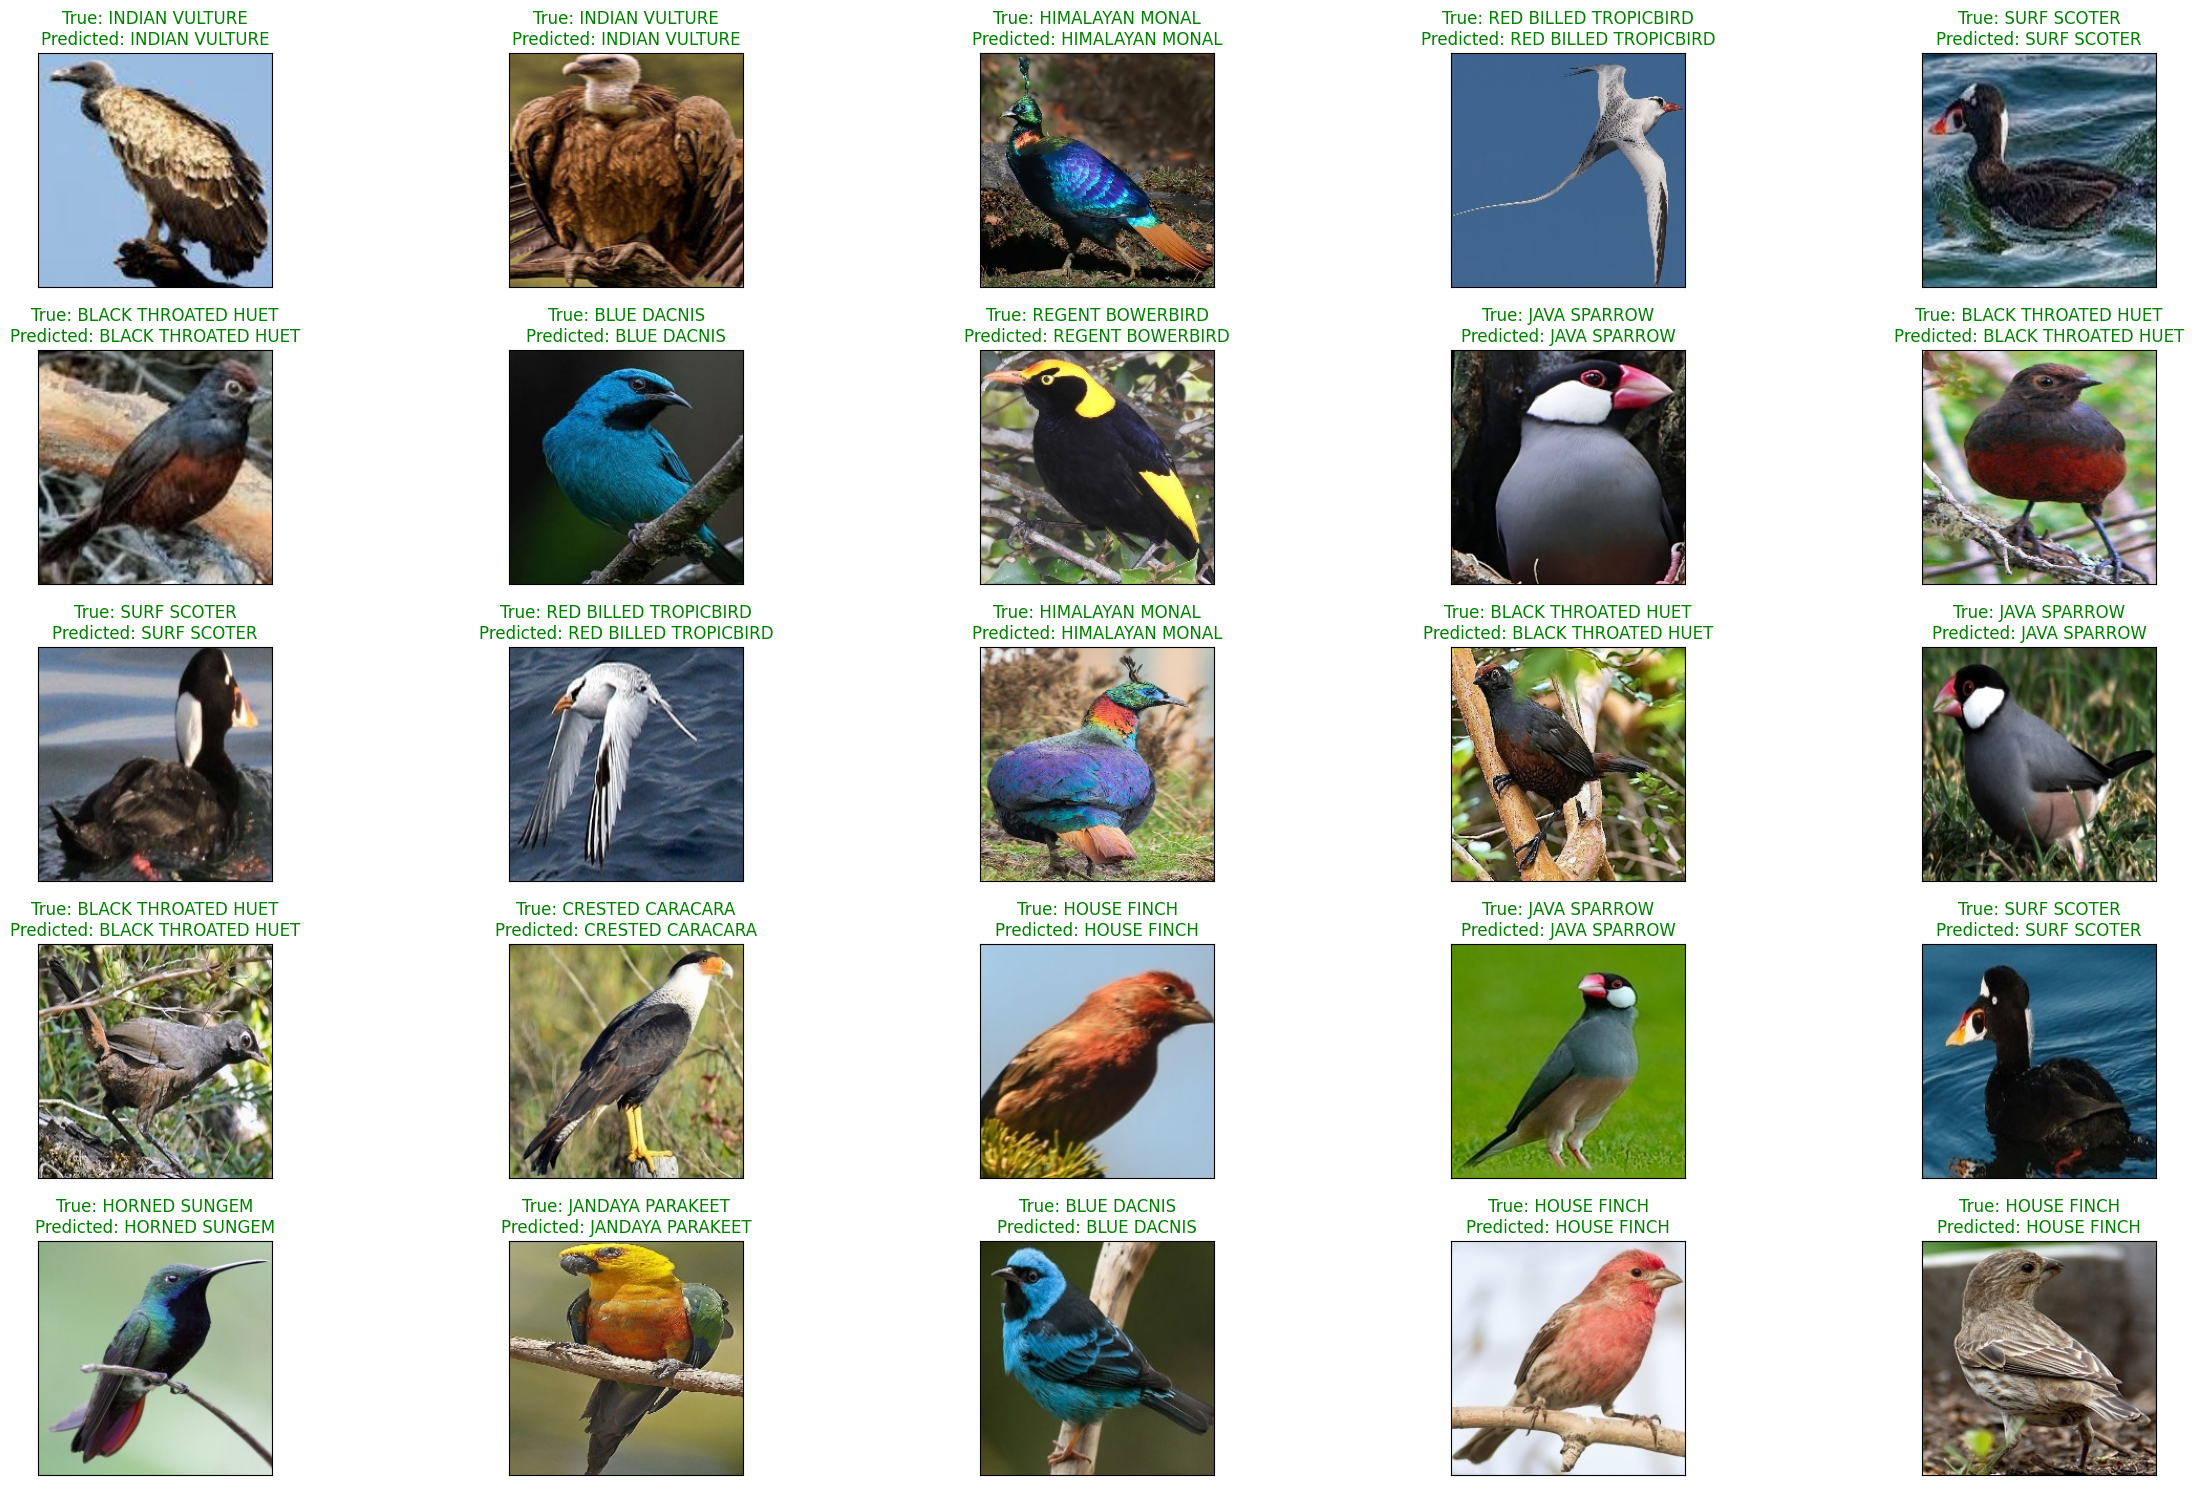

In [26]:
# display 25 random pictures from the test dataset with their true and predicted labels
random_index = np.random.randint(0, len(test_df) - 1, 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.tight_layout()

In [27]:
print("Classification Report")
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

Classification Report


precision    recall  f1-score      support
BLACK THROATED HUET       0.986111  1.000000  0.993007    71.000000
BLUE DACNIS               1.000000  1.000000  1.000000    75.000000
CHIPPING SPARROW          0.963636  1.000000  0.981481    53.000000
CRESTED CARACARA          1.000000  0.984127  0.992000    63.000000
CURL CRESTED ARACURI      1.000000  1.000000  1.000000    57.000000
HIMALAYAN MONAL           1.000000  0.982456  0.991150    57.000000
HORNED SUNGEM             1.000000  1.000000  1.000000    57.000000
HOUSE FINCH               1.000000  0.970874  0.985222   103.000000
INDIAN VULTURE            0.969231  1.000000  0.984375    63.000000
JANDAYA PARAKEET          0.986111  1.000000  0.993007    71.000000
JAVA SPARROW              0.986486  1.000000  0.993197    73.000000
RED BILLED TROPICBIRD     1.000000  1.000000  1.000000    68.000000
REGENT BOWERBIRD          1.000000  1.000000  1.000000    60.000000
SCARLET FACED LIOCICHLA   1.000000  0.984375  0.992126    64.000000
SURF SCOTER               1.000000  0.986667  0.993289    75.000000
accuracy                  0.993069  0.993069  0.993069     0.993069
macro avg                 0.992772  0.993900  0.993257  1010.000000
weighted avg              0.993243  0.993069  0.993076  1010.000000

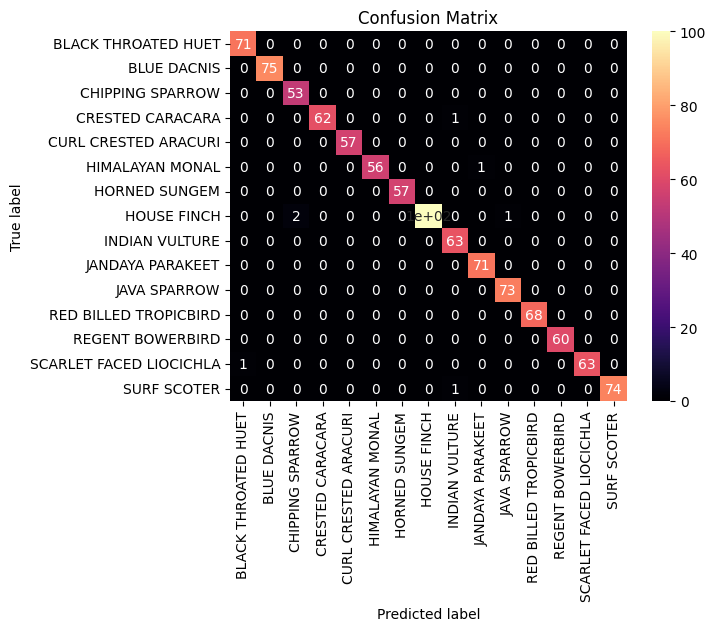

In [28]:
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, cmap='magma')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(np.arange(15)+0.5, labels=list(labels.values()), rotation=90)
plt.yticks(np.arange(15)+0.5, labels=list(labels.values()), rotation=0);

# Bonus visualization

In [29]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # adding a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # save the superimposed image
    superimposed_img.save(cam_path)

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224, 3)

# remove last layer's softmax
model.layers[-1].activation = None

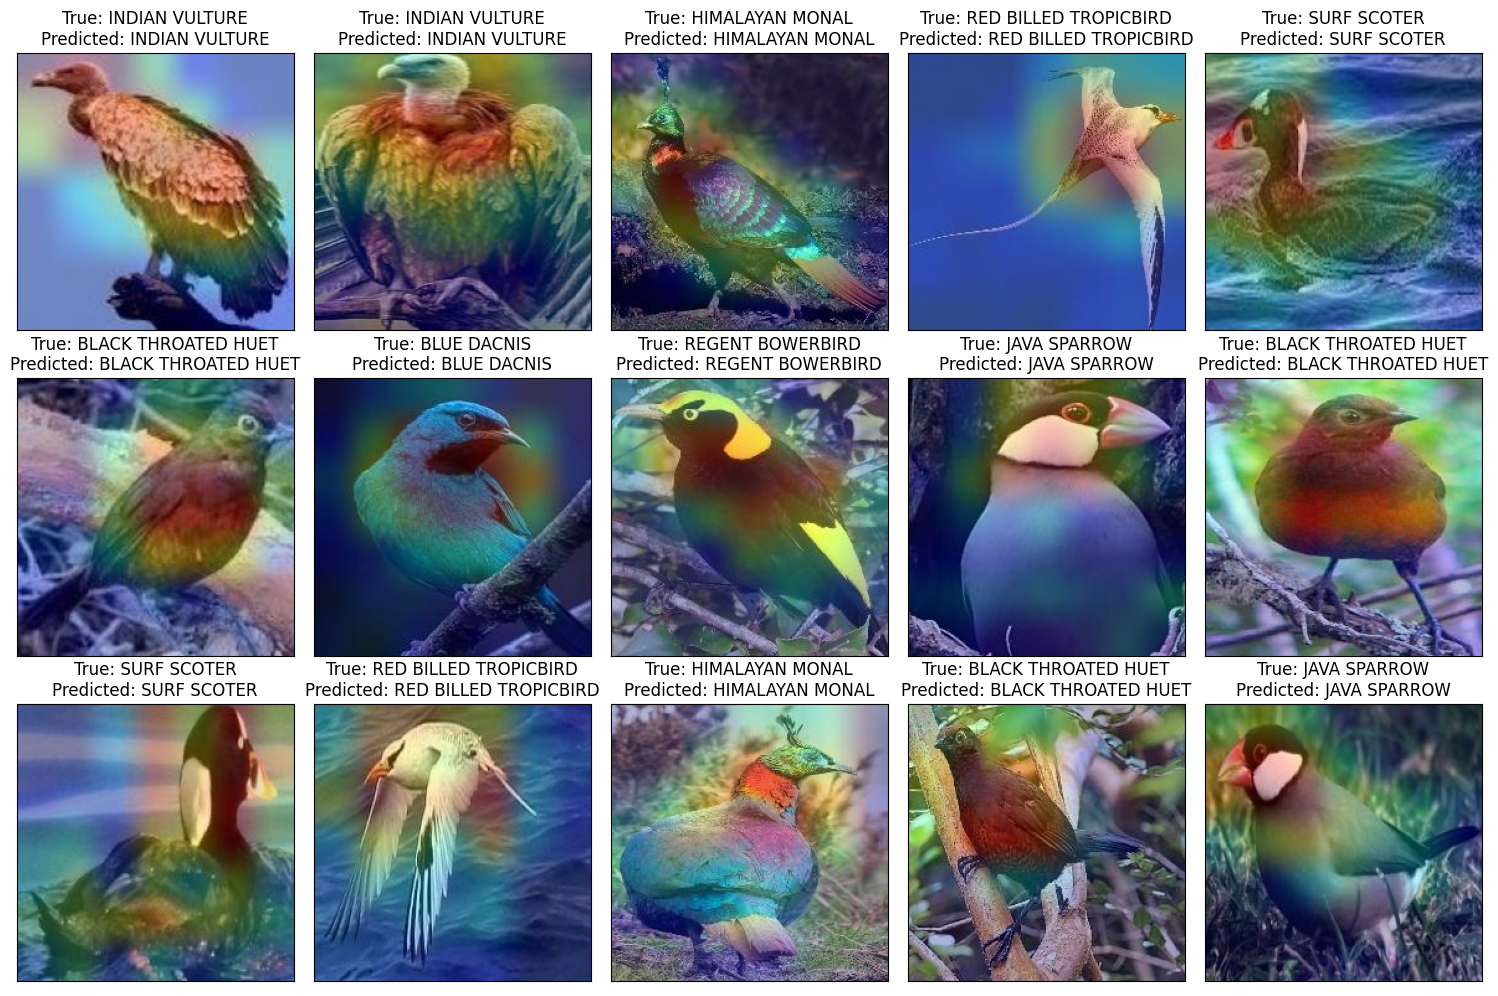

In [30]:
# display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()